In [30]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
import mlflow
import pytest
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

In [2]:
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='file:///workspaces/mlops/02-experiment-tracking/mlruns/245585800227000005', creation_time=1719142135182, experiment_id='245585800227000005', last_update_time=1719142135182, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829626

/tmp/ipykernel_138141/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_138141/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


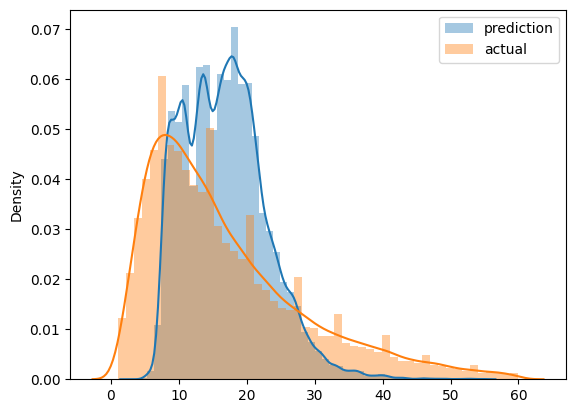

In [5]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [8]:
len(df_train), len(df_val)

(73908, 61921)

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [9]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [10]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.7587152107032376

In [13]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
with mlflow.start_run(): 
    
    mlflow.set_tag("developer", "yong chein")
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact(local_path = 'models/lin_reg.bin')

In [12]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [31]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                             | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:22:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.42018                                                                              
[1]	validation-rmse:8.00782                                                                              
[2]	validation-rmse:7.33562                                                                              
[3]	validation-rmse:7.01897                                                                              
[4]	validation-rmse:6.87086                                                                              
[5]	validation-rmse:6.78991                                                                              
[6]	validation-rmse:6.74738                                                                              
[7]	validation-rmse:6.72420                                                                              
[8]	validation-rmse:6.70687                                                                              
[9]	validation-rmse:6.69452                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:24:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77285                                                                             
[1]	validation-rmse:11.36293                                                                             
[2]	validation-rmse:10.98206                                                                             
[3]	validation-rmse:10.62868                                                                             
[4]	validation-rmse:10.30091                                                                             
[5]	validation-rmse:9.99710                                                                              
[6]	validation-rmse:9.71609                                                                              
[7]	validation-rmse:9.45648                                                                              
[8]	validation-rmse:9.21613                                                                              
[9]	validation-rmse:8.99486                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:27:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.94439                                                                              
[1]	validation-rmse:8.56510                                                                              
[2]	validation-rmse:7.74959                                                                              
[3]	validation-rmse:7.28631                                                                              
[4]	validation-rmse:7.01705                                                                              
[5]	validation-rmse:6.86674                                                                              
[6]	validation-rmse:6.76665                                                                              
[7]	validation-rmse:6.70857                                                                              
[8]	validation-rmse:6.67269                                                                              
[9]	validation-rmse:6.64934                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:29:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.64200                                                                             
[1]	validation-rmse:9.48886                                                                              
[2]	validation-rmse:8.65740                                                                              
[3]	validation-rmse:8.06789                                                                              
[4]	validation-rmse:7.65563                                                                              
[5]	validation-rmse:7.36800                                                                              
[6]	validation-rmse:7.16742                                                                              
[7]	validation-rmse:7.03029                                                                              
[8]	validation-rmse:6.93290                                                                              
[9]	validation-rmse:6.86160                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:31:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.36301                                                                              
[1]	validation-rmse:7.18678                                                                              
[2]	validation-rmse:6.83943                                                                              
[3]	validation-rmse:6.72299                                                                              
[4]	validation-rmse:6.68033                                                                              
[5]	validation-rmse:6.65990                                                                              
[6]	validation-rmse:6.64815                                                                              
[7]	validation-rmse:6.64404                                                                              
[8]	validation-rmse:6.63694                                                                              
[9]	validation-rmse:6.63067                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:32:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99864                                                                              
[1]	validation-rmse:7.55302                                                                              
[2]	validation-rmse:6.94871                                                                              
[3]	validation-rmse:6.69235                                                                              
[4]	validation-rmse:6.57441                                                                              
[5]	validation-rmse:6.51765                                                                              
[6]	validation-rmse:6.48772                                                                              
[7]	validation-rmse:6.47044                                                                              
[8]	validation-rmse:6.45779                                                                              
[9]	validation-rmse:6.44619                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:33:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69124                                                                             
[1]	validation-rmse:11.21322                                                                             
[2]	validation-rmse:10.77596                                                                             
[3]	validation-rmse:10.37687                                                                             
[4]	validation-rmse:10.01284                                                                             
[5]	validation-rmse:9.68179                                                                              
[6]	validation-rmse:9.38040                                                                              
[7]	validation-rmse:9.10742                                                                              
[8]	validation-rmse:8.85956                                                                              
[9]	validation-rmse:8.63507                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:35:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.25850                                                                              
[1]	validation-rmse:6.76982                                                                              
[2]	validation-rmse:6.68523                                                                              
[3]	validation-rmse:6.65728                                                                              
[4]	validation-rmse:6.64612                                                                              
[5]	validation-rmse:6.64083                                                                              
[6]	validation-rmse:6.63292                                                                              
[7]	validation-rmse:6.62510                                                                              
[8]	validation-rmse:6.61797                                                                              
[9]	validation-rmse:6.61612                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:36:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.49447                                                                             
[1]	validation-rmse:9.26534                                                                              
[2]	validation-rmse:8.40664                                                                              
[3]	validation-rmse:7.81612                                                                              
[4]	validation-rmse:7.41522                                                                              
[5]	validation-rmse:7.14818                                                                              
[6]	validation-rmse:6.96752                                                                              
[7]	validation-rmse:6.84518                                                                              
[8]	validation-rmse:6.75904                                                                              
[9]	validation-rmse:6.69839                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:38:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.51577                                                                             
[1]	validation-rmse:10.89460                                                                             
[2]	validation-rmse:10.34304                                                                             
[3]	validation-rmse:9.85506                                                                              
[4]	validation-rmse:9.42513                                                                              
[5]	validation-rmse:9.04569                                                                              
[6]	validation-rmse:8.71149                                                                              
[7]	validation-rmse:8.41912                                                                              
[8]	validation-rmse:8.16401                                                                              
[9]	validation-rmse:7.94226                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:43:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.14918                                                                              
[1]	validation-rmse:7.00964                                                                              
[2]	validation-rmse:6.70386                                                                              
[3]	validation-rmse:6.60507                                                                              
[4]	validation-rmse:6.56481                                                                              
[5]	validation-rmse:6.54746                                                                              
[6]	validation-rmse:6.53973                                                                              
[7]	validation-rmse:6.52983                                                                              
[8]	validation-rmse:6.52615                                                                              
[9]	validation-rmse:6.51800                   

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:43:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74999                                                                             
[1]	validation-rmse:11.32050                                                                             
[2]	validation-rmse:10.92250                                                                             
[3]	validation-rmse:10.55405                                                                             
[4]	validation-rmse:10.21348                                                                             
[5]	validation-rmse:9.89894                                                                              
[6]	validation-rmse:9.60909                                                                              
[7]	validation-rmse:9.34214                                                                              
[8]	validation-rmse:9.09631                                                                              
[9]	validation-rmse:8.87096                   

KeyboardInterrupt: 

In [16]:
params = {
    'reg_alpa': 0.05574104850855629,
    'objective': 'reg:linear',
    'reg_lambda': 0.0027226266500792206,
    'seed': 42,
    'max_depth': 74,
    'learning_rate': 0.42275895717217415,
    'min_child_weight': 2.1295360360458457
}

# autologging with mlflow
mlflow.xgboost.autolog()
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=50,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2024/06/23 13:05:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c7dddc3e031147509083909328a085fc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [13:05:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [13:05:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "reg_alpa" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.99869
[1]	validation-rmse:7.55461
[2]	validation-rmse:6.94916
[3]	validation-rmse:6.69154
[4]	validation-rmse:6.57542
[5]	validation-rmse:6.52132
[6]	validation-rmse:6.49083
[7]	validation-rmse:6.46968
[8]	validation-rmse:6.45751
[9]	validation-rmse:6.44701
[10]	validation-rmse:6.44030
[11]	validation-rmse:6.43259
[12]	validation-rmse:6.42864
[13]	validation-rmse:6.42596
[14]	validation-rmse:6.42279
[15]	validation-rmse:6.41791
[16]	validation-rmse:6.41423
[17]	validation-rmse:6.40873
[18]	validation-rmse:6.40574
[19]	validation-rmse:6.40325
[20]	validation-rmse:6.40086
[21]	validation-rmse:6.39730
[22]	validation-rmse:6.39429
[23]	validation-rmse:6.39141
[24]	validation-rmse:6.39005
[25]	validation-rmse:6.38952
[26]	validation-rmse:6.38778
[27]	validation-rmse:6.38570
[28]	validation-rmse:6.38503
[29]	validation-rmse:6.38346
[30]	validation-rmse:6.38285
[31]	validation-rmse:6.38203
[32]	validation-rmse:6.38078
[33]	validation-rmse:6.38015
[34]	validation-rmse:6.3

2024/06/23 13:06:11 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/06/23 13:06:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [13:06:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [25]:
with mlflow.start_run(): 
    params = {
        'reg_alpa': 0.05,
        'objective': 'reg:squarederror',
        'reg_lambda': 0.003,
        'seed': 42,
        'max_depth': 30,
        'learning_rate': 0.4,
        'min_child_weight': 2.1
    }
    mlflow.log_params(params)
    
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=10,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.bin", "wb") as f: 
        pickle.dump(dv, f)
    
    mlflow.log_artifact("models/preprocessor.bin", artifact_path = "preprocessor")
    mlflow.xgboost.log_model(booster, artifact_path = 'models_mlflow')


/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:01:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "reg_alpa" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.19462
[1]	validation-rmse:7.75376
[2]	validation-rmse:7.10803
[3]	validation-rmse:6.82177
[4]	validation-rmse:6.68581
[5]	validation-rmse:6.61595
[6]	validation-rmse:6.57556
[7]	validation-rmse:6.55370
[8]	validation-rmse:6.53963
[9]	validation-rmse:6.52758


/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:01:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [18]:
logged_model = 'runs:/fc772e34d61d41ee9825da8ae5cc24f2/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [13:47:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: fc772e34d61d41ee9825da8ae5cc24f2

In [19]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

/opt/conda/envs/mlflow_env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [13:48:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [22]:
y_pred = xgboost_model.predict(valid)
y_pred

array([14.79381 ,  7.393699, 14.228477, ..., 14.261883,  6.344534,
        8.44572 ], dtype=float32)

In [59]:
client = MlflowClient()
runs = client.search_runs(
    experiment_ids = '245585800227000005',
    filter_string = "metrics.rmse < 6.8",
    run_view_type = ViewType.ACTIVE_ONLY,
    max_results = 5, 
    order_by = ["metrics.rmse ASC"]
)

In [60]:
for run in runs: 
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:4f}")

run id: 1f52273228e94b5a8c89a4812e78d7f0, rmse: 6.319734
run id: 62e37e5508eb490795ad85a75213f924, rmse: 6.343620
run id: 4036b5988a244d6f9453c62a077762f3, rmse: 6.362209
run id: 2d7e5aa1ef434019a9307be87266136b, rmse: 6.366076
run id: 864fe4caa1a940028c7d8c621f3b15cd, rmse: 6.372920


In [69]:
client.get_registered_model(name= "nyc-taxi-regressor")

<RegisteredModel: aliases={}, creation_timestamp=1719151159117, description='NYC taxi predictor for duration', last_updated_timestamp=1719151810530, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1719151316837, current_stage='None', description='', last_updated_timestamp=1719151316837, name='nyc-taxi-regressor', run_id='4a08ad8f9f964696a802152f14fbe121', run_link='', source='file:///workspaces/mlops/02-experiment-tracking/mlruns/245585800227000005/4a08ad8f9f964696a802152f14fbe121/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=2>], name='nyc-taxi-regressor', tags={}>